##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transporter

## Introduction

This notebook contains an example describing how to use the `Transporter` architecture as described in [Unsupervised Learning of Object Keypoints for Perception and Control](https://arxiv.org/abs/1906.11883).

In this notebook, we show how to create a model, and how to use it to perform inference on single images. The model is loaded from a pre-trained Transporter model checkpoint. The data consists of a full episode of Pong obtained from a random agent.

## Contact
For questions or bug reports, please create an issue in the [GitHub repository](https://github.com/deepmind/deepmind-research/transporter).

## Load files into colab
To run this colab you will need to upload the `transporter.py` file. 

You can do this by dragging and dropping the files into the `Files` tab in the left pane.

In [0]:
#@title Load Pong frames and checkpoint from GCS
!gsutil cp gs://transporter-data/pong_episode.npy ./pong_episode.npy
!gsutil cp gs://transporter-data/transporter_ckpt* ./

In [0]:
#@title Imports
from matplotlib import animation, cm
from matplotlib import pyplot as plt
import numpy as np
import PIL
from PIL import Image, ImageDraw
import tensorflow as tf

from IPython.display import HTML
from base64 import b64encode

import transporter

In [0]:
#@title Plotting functions
def plot_keypoints_on_image(im, kpts, r=5, alpha=1.0, image_size=(128, 128)):
  im = (im.copy() * alpha).astype(np.uint8)
  scaled_kpts = kpts.copy()
  scaled_kpts = (scaled_kpts + 1.0) * 0.5 * np.array(list(image_size))[None,:]
  scaled_kpts = scaled_kpts.astype(np.int)
  temp = scaled_kpts.copy()
  if not isinstance(im, Image.Image):
    im = Image.fromarray(im)
  
  im = im.resize(image_size, PIL.Image.BILINEAR)
  n_kpts = scaled_kpts.shape[0]
  colors = [tuple(c) for c in (cm.rainbow(np.linspace(0,1,n_kpts)) * 255).astype(np.int32)]
  draw = ImageDraw.Draw(im)
  for i in range(len(scaled_kpts)):
    y,x = scaled_kpts[i].astype(np.int32)
    draw.ellipse((x-r, y-r, x+r, y+r), fill=colors[i])
  return np.array(im), temp

def save_video(frames, fname):
  fig = plt.figure(figsize=(10, 10))
  video = []
  for frame in frames:
    im = plt.imshow(frame, animated=True, interpolation='nearest')
    video.append([im])
  ani = animation.ArtistAnimation(
      fig, video, interval=50, blit=True, repeat_delay=1000)
  ani.save(fname)

In [0]:
#@title Model params
ckpt_path = 'transporter_ckpt'

norm_type = 'instance'
convnet_encoder_kwargs=dict(
    filters=(16, 16, 32, 32),
    strides=(1, 1, 2, 1),
    kernel_sizes=(7, 3, 3, 3),
)
decoder_num_filters=128

num_keypoints=5
gauss_std=0.1
norm_type='instance'

image_shape = (128, 128)

In [5]:
#@title Build the model
tf.reset_default_graph()
encoder = transporter.Encoder(
    name='encoder',
    norm_type=norm_type,
    **convnet_encoder_kwargs)
keypoint_encoder = transporter.Encoder(
    name='keypoint_encoder',
    norm_type=norm_type,
    **convnet_encoder_kwargs)

decoder = transporter.Decoder(
    initial_filters=decoder_num_filters,
    output_size=image_shape,
    norm_type=norm_type)

keypointer = transporter.KeyPointer(
    num_keypoints=num_keypoints,
    gauss_std=gauss_std,
    keypoint_encoder=keypoint_encoder)

model = transporter.Transporter(
    encoder=encoder,
    decoder=decoder,
    keypointer=keypointer)

image_a_pl = tf.placeholder(
    shape=(1, image_shape[0], image_shape[1], 3), 
    dtype=tf.float32)

image_b_pl = tf.placeholder(
    shape=(1, image_shape[0], image_shape[1], 3), 
    dtype=tf.float32)

outputs_tf = model(image_a_pl, image_b_pl, is_training=False)




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



In [6]:
#@title Run the model and extract the keypoints
input_pixels = np.load('pong_episode.npy')

# Add ops to save and restore all the variables.
variables_map = {v.name[:-2]: v for v in tf.trainable_variables()}
saver = tf.train.Saver(var_list=variables_map)

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, ckpt_path)

  im_keypoints = []
  reconstructed_frames = []
  for im in input_pixels:
    output = sess.run(outputs_tf, {
        image_a_pl: im[None],  # Add extra batch dimension
        image_b_pl: im[None], 
    })
    im_keypoints.append(output['keypoints_b']['centers'][0])
    reconstructed_frames.append(output['reconstructed_image_b'][0])

INFO:tensorflow:Restoring parameters from transporter_ckpt


In [0]:
#@title Create output videos
keypoint_frames = []
scaled_kpts = []
for i in range(len(im_keypoints)):
    keypoints = im_keypoints[i]
    kpt_frame, temp = plot_keypoints_on_image(input_pixels[i], keypoints, r=3)
    keypoint_frames.append(kpt_frame)
    scaled_kpts.append(temp)
keypoint_frames = np.array(keypoint_frames)

reconstructed_frames = np.clip(
    np.array(reconstructed_frames), 0, 255).astype(np.uint8)

collage = np.concatenate(
    [input_pixels, keypoint_frames, reconstructed_frames], axis=2)


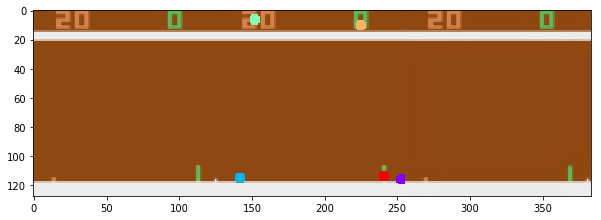

In [8]:
#@title Save the video to the Colab files

save_video(collage, 'collage.mp4')

In [9]:
#@title Display the video (ground truth, keypoints, reconstruction)
mp4 = open('collage.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)